In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
scored_test_data = pd.read_csv('scored_test_data.csv', index_col=0)
scored_train_data = pd.read_csv('scored_train_data.csv', index_col=0)

## Dummy variables

In [4]:
dummies_category_test = pd.get_dummies(scored_test_data['Category'])
dummies_badges_test = scored_test_data['Badges'].str.strip('{}').str.replace('"', '').str.get_dummies(',')

dummies_category_train = pd.get_dummies(scored_train_data['Category'])
dummies_badges_train = scored_train_data['Badges'].str.strip('{}').str.replace('"', '').str.get_dummies(',')

In [5]:
dropped_cols_test = scored_test_data.drop(['Category','Badges'], axis = 1)

dropped_cols_train = scored_train_data.drop(['Category','Badges'], axis = 1)

In [22]:
complete_test_data = pd.concat([dropped_cols_test,dummies_badges_test, dummies_category_test], axis = 1)

complete_train_data = pd.concat([dropped_cols_train,dummies_badges_train, dummies_category_train], axis = 1)

In [23]:
col_interactions_test = complete_test_data.pop('interaction')
col_interactions_train = complete_train_data.pop('interaction')


complete_test_data.insert(len(complete_test_data.columns), 'interaction', col_interactions_test)
complete_train_data.insert(len(complete_train_data.columns), 'interaction', col_interactions_train)

In [24]:
complete_test_data = complete_test_data.dropna()
complete_train_data = complete_train_data.dropna()

In [9]:
complete_test_data.to_csv('scored_test_data_wth_dummies.csv')
complete_train_data.to_csv('scored_train_data_wth_dummies.csv')

# Distribution

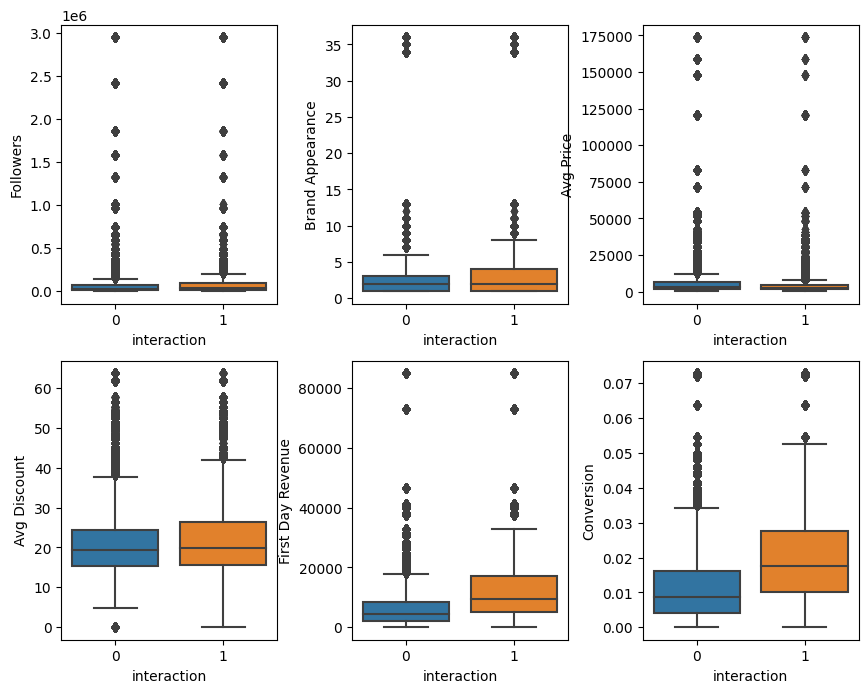

In [11]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(9,7))
fig.tight_layout(pad=2)

for i, col in enumerate(dropped_cols_train.columns[3:-4]):
    sns.boxplot(y = col, x = "interaction",data=dropped_cols_train, orient='v', ax=axes[int(i/3),i%3])

## Distribution

In [12]:
target = 'interaction'

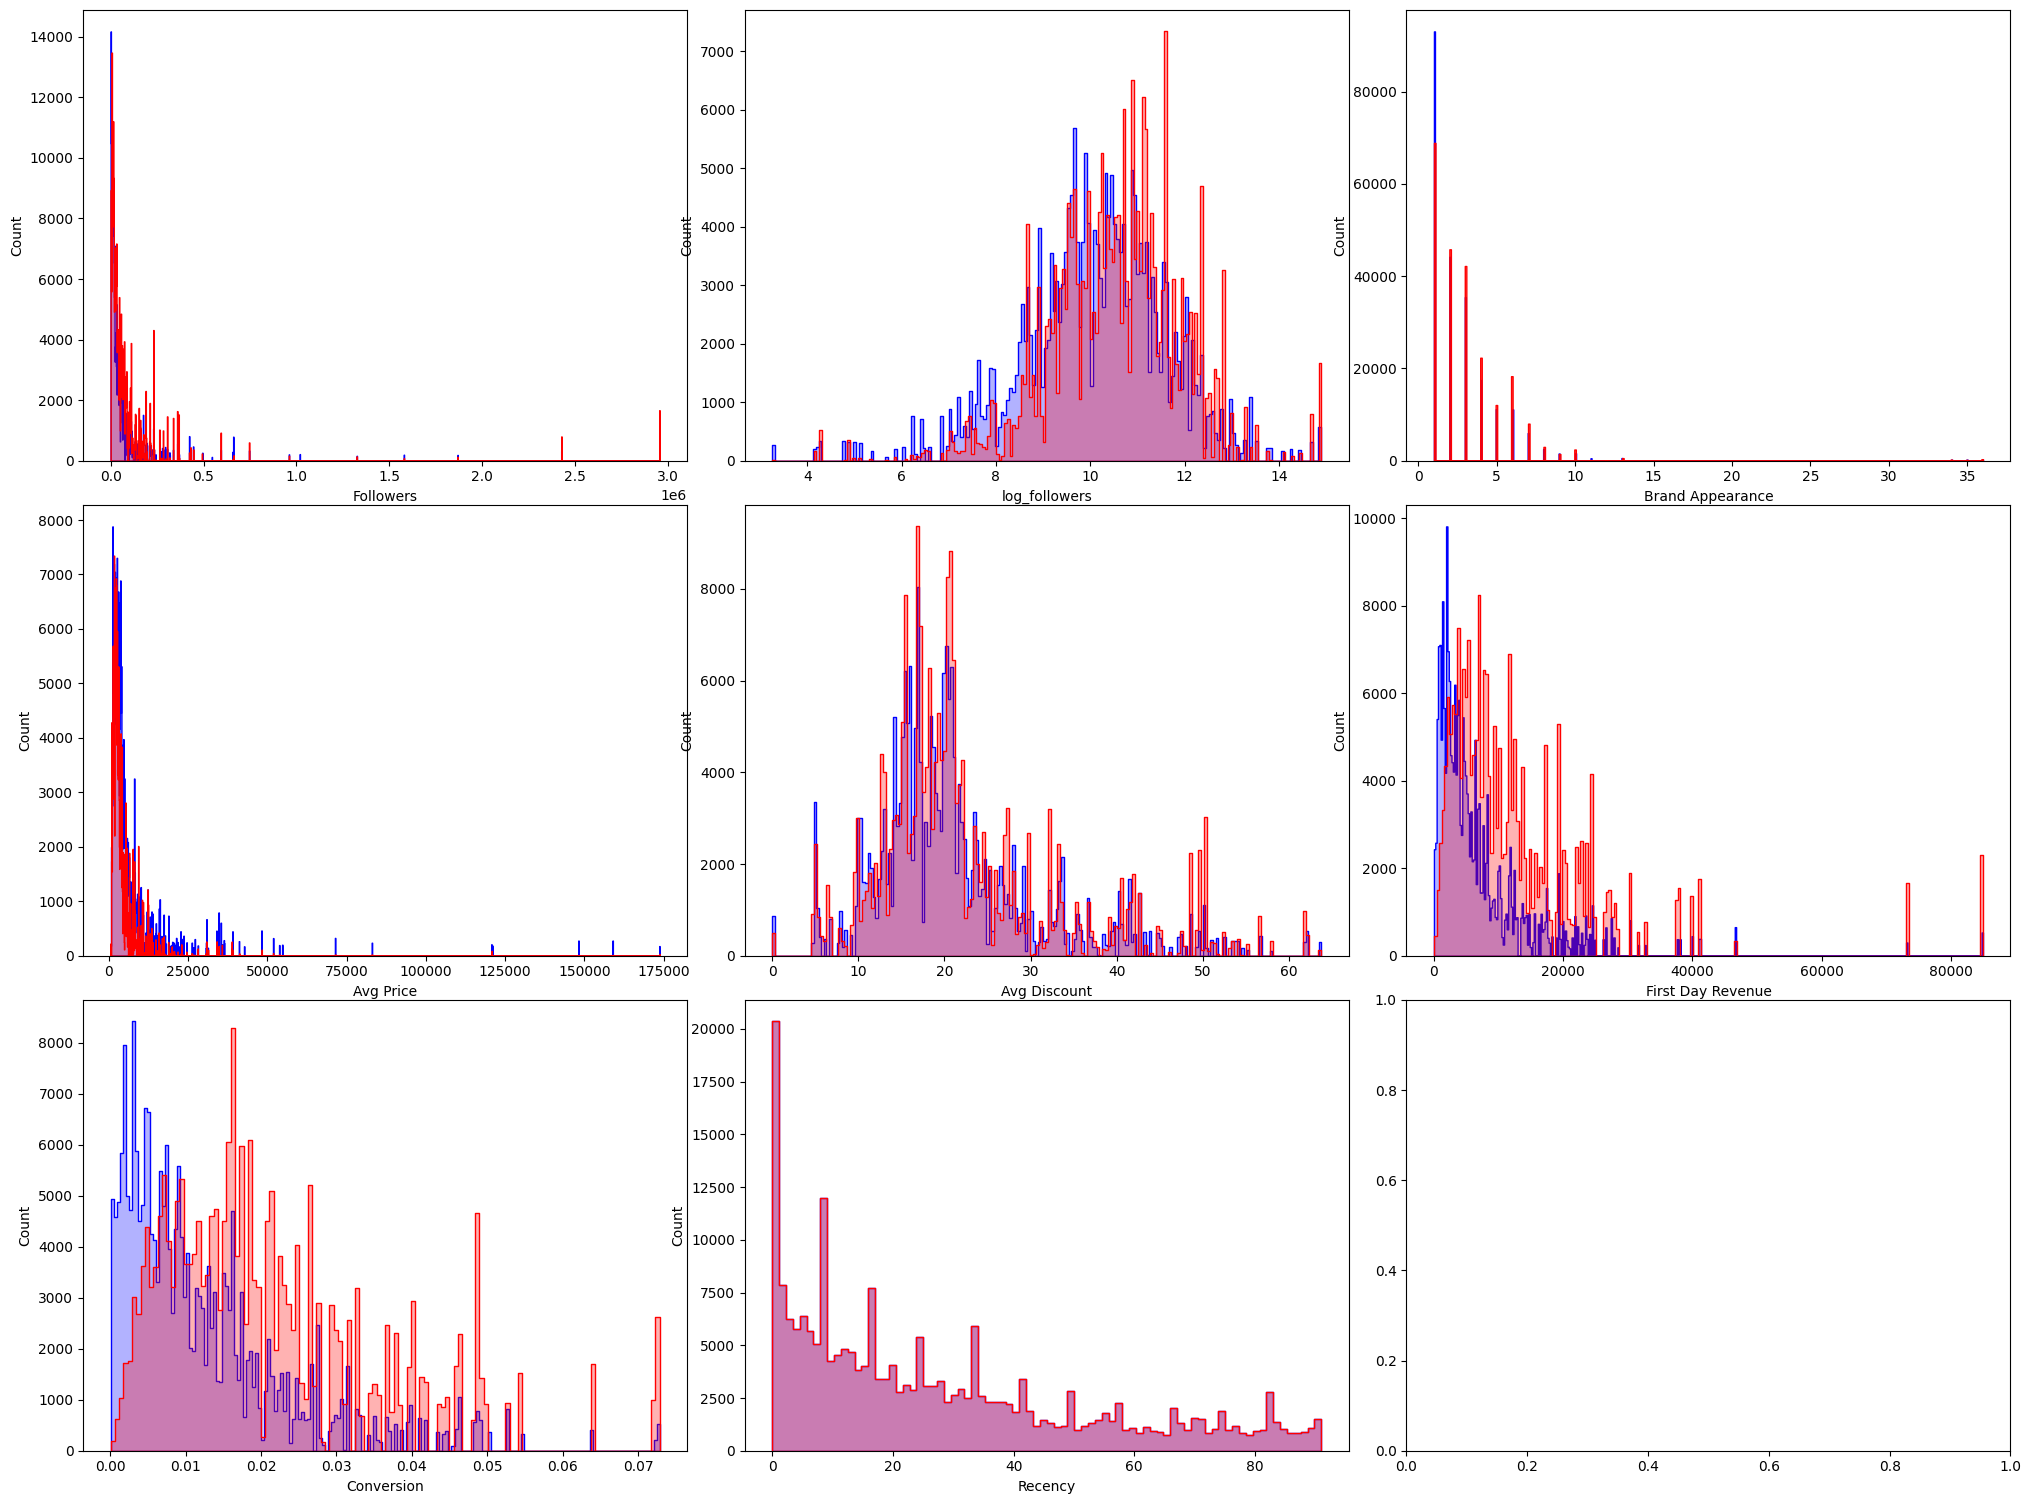

In [31]:
X= complete_train_data

X0 = X[X[target]==0]
X1 = X[X[target]==1]

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(20,15))
fig.tight_layout()

for i, ax in zip(range(3,9), axes.flat):
    sns.histplot((X0.iloc[:,i]), color="blue", element="step", ax=ax,  alpha=0.3) #alpha is transparency!
    sns.histplot((X1.iloc[:,i]), color="red", element="step", ax=ax,  alpha=0.3)
plt.show()

In [29]:
# complete_train_data.insert(4,'log_followers', np.log(complete_train_data['Followers']))
complete_test_data.insert(7, 'log_avg_price',np.log(complete_test_data['Avg Price']))

In [33]:
def adding_log(train: pd.DataFrame, test: pd.DataFrame, columns_to_log: list):
    """ 
    Adding columns using log of provided information.
    """
    for column_name in columns_to_log:
        position = train.get_loc(str(column_name))

    